LIBRERIAS

In [1]:
import os
import sys
import random
import json
import math
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, LambdaLR
from torchvision import transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Dispositivo: {device}")

🚀 Dispositivo: cuda


DATASET Y DATALOADER

In [2]:
class Pix2PixDataset(Dataset):
    def __init__(self, root, size=256, augment=False):
        self.dir_A = os.path.join(root, "A")
        self.dir_B = os.path.join(root, "B")
        self.augment = augment
        self.size = size

        self.files = sorted([f.replace('.npy', '') for f in os.listdir(self.dir_A) if f.endswith('.npy')])
        print(f"📊 Dataset: {len(self.files)} pares")

        # Transformaciones para imágenes RGB (SIN flip aleatorio aquí)
        transforms_list = [
            transforms.Resize((size, size), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ]
        
        if augment:
            # Solo color jitter u otras cosas que no cambien geometría
            transforms_list.insert(1, transforms.ColorJitter(
                brightness=0.05, contrast=0.05, saturation=0.05, hue=0.01
            ))
        
        self.transform = transforms.Compose(transforms_list)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]
        
        # Cargar heatmap A
        A = np.load(os.path.join(self.dir_A, f"{name}.npy"))
        if A.ndim == 2:
            A = A[None, ...]  # (1, H, W)
        A = torch.from_numpy(A).float() / 127.5 - 1.0  # Normalizar [-1, 1]
        
        # Cargar imagen B
        b_path = os.path.join(self.dir_B, f"{name}.jpg")
        if not os.path.exists(b_path):
            b_path = os.path.join(self.dir_B, f"{name}.png")
        
        B = Image.open(b_path)
        if B.mode == 'RGBA':
            rgb = Image.new("RGB", B.size, (255, 255, 255))
            rgb.paste(B, mask=B.split()[3])
            B = rgb
        elif B.mode != 'RGB':
            B = B.convert("RGB")
        
        B = self.transform(B)
        
        # Flip horizontal CONSISTENTE entre A y B
        if self.augment and random.random() > 0.5:
            # dim=2 es el eje ancho (W): (C, H, W)
            A = torch.flip(A, dims=[2])
            B = torch.flip(B, dims=[2])
        
        return A, B


VISUALIZACIÓN INICIAL DEL DATASET

In [3]:
def visualize_dataset(dataset_root="datasets/catflw/train", n=3):
    """Muestra ejemplos del dataset: landmarks, imagen real, y ambas superpuestas"""
    dataset = Pix2PixDataset(dataset_root)
    loader = DataLoader(dataset, batch_size=n, shuffle=True)
    A, B = next(iter(loader))
    
    denorm = lambda x: (x * 0.5 + 0.5).clamp(0, 1)
    
    fig, axes = plt.subplots(n, 3, figsize=(12, 4*n))
    if n == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n):
        a = denorm(A[i]).squeeze(0).cpu().numpy()
        b_img = denorm(B[i]).permute(1, 2, 0).cpu().numpy()
        
        overlay = b_img.copy()
        a_colored = plt.cm.hot(a)[:,:,:3]
        overlay = overlay * 0.6 + a_colored * 0.4
        
        axes[i, 0].imshow(a, cmap='hot')
        axes[i, 0].set_title("Heatmap")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(b_img)
        axes[i, 1].set_title("Imagen Real")
        axes[i, 1].axis("off")
        
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title("Superposición")
        axes[i, 2].axis("off")
    
    plt.tight_layout()
    os.makedirs("results", exist_ok=True)
    plt.savefig("results/dataset_samples.png", bbox_inches="tight", dpi=150)
    plt.show()
    print("🖼️ Visualización guardada en results/dataset_samples.png")


def compare_original_processed(sample_name="00000001_008", raw_root="CatFLW dataset", 
                               proc_root="datasets/catflw/train"):
    """Compara imagen original con la procesada"""
    raw_img_path = os.path.join(raw_root, "images", sample_name + ".png")
    raw_json_path = os.path.join(raw_root, "labels", sample_name + ".json")
    proc_A_path = os.path.join(proc_root, "A", sample_name + ".npy")
    proc_B_png = os.path.join(proc_root, "B", sample_name + ".png")
    proc_B_jpg = os.path.join(proc_root, "B", sample_name + ".jpg")
    proc_B_path = proc_B_png if os.path.exists(proc_B_png) else proc_B_jpg

    if not (os.path.exists(raw_img_path) and os.path.exists(raw_json_path) and 
            os.path.exists(proc_A_path) and os.path.exists(proc_B_path)):
        print("⚠️ Archivos requeridos no encontrados para", sample_name)
        return

    raw_img = Image.open(raw_img_path).convert("RGB")
    with open(raw_json_path, 'r') as f:
        data = json.load(f)
    coords = np.array(data.get("labels") or data.get("landmarks"))
    bbox = np.array(data.get("bounding_boxes") or data.get("bbox"))

    heatmap = np.load(proc_A_path)
    if heatmap.ndim == 3:
        heatmap = heatmap[0]
    proc_img = Image.open(proc_B_path).convert("RGB")

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    
    axes[0, 0].imshow(raw_img)
    if bbox.size >= 4:
        x1, y1, x2, y2 = bbox.astype(int)[:4]
        axes[0, 0].add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                          fill=False, edgecolor='lime', linewidth=2))
    axes[0, 0].set_title('Original + BBox')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(raw_img)
    axes[0, 1].scatter(coords[:, 0], coords[:, 1], s=10, c='yellow')
    axes[0, 1].set_title('Original + Landmarks')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(proc_img)
    axes[0, 2].set_title('Procesada')
    axes[0, 2].axis('off')

    axes[1, 0].imshow(heatmap, cmap='hot')
    axes[1, 0].set_title('Heatmap')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(heatmap, cmap='hot')
    axes[1, 1].set_title('Heatmap zoom')
    axes[1, 1].axis('off')

    axes[1, 2].imshow(proc_img)
    axes[1, 2].imshow(heatmap, alpha=0.5, cmap='hot')
    axes[1, 2].set_title('Overlay')
    axes[1, 2].axis('off')

    plt.tight_layout()
    os.makedirs('results', exist_ok=True)
    plt.savefig('results/compare_original_processed.png', bbox_inches='tight', dpi=150)
    plt.show()
    print('🖼️ Guardado en results/compare_original_processed.png')

MODELO PIX2PIX (U-Net + PatchGAN)

In [4]:
class UNetGenerator(nn.Module):
    """U-Net Generator mejorado con mejor normalización"""
    def __init__(self, in_ch=1, out_ch=3):
        super().__init__()
        
        # Encoder con Instance Normalization
        self.enc1 = self._block(in_ch, 64, normalize=False)
        self.enc2 = self._block(64, 128)
        self.enc3 = self._block(128, 256)
        self.enc4 = self._block(256, 512)
        self.enc5 = self._block(512, 512)
        self.enc6 = self._block(512, 512)
        self.enc7 = self._block(512, 512)
        self.enc8 = self._block(512, 512, normalize=False)
        
        # Decoder con dropout selectivo
        self.dec1 = self._block(512, 512, decode=True, dropout=True)
        self.dec2 = self._block(1024, 512, decode=True, dropout=True)
        self.dec3 = self._block(1024, 512, decode=True, dropout=True)
        self.dec4 = self._block(1024, 512, decode=True)
        self.dec5 = self._block(1024, 256, decode=True)
        self.dec6 = self._block(512, 128, decode=True)
        self.dec7 = self._block(256, 64, decode=True)
        
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_ch, 4, 2, 1),
            nn.Tanh()
        )
    
    def _block(self, in_c, out_c, normalize=True, decode=False, dropout=False):
        layers = []
        if decode:
            layers.append(nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False))
        else:
            layers.append(nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False))
        
        if normalize:
            # Usar Instance Normalization en lugar de Batch Normalization
            layers.append(nn.InstanceNorm2d(out_c, affine=True))
        
        layers.append(nn.LeakyReLU(0.2, True) if not decode else nn.ReLU(True))
        
        if dropout:
            layers.append(nn.Dropout(0.5))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)
        e7 = self.enc7(e6)
        e8 = self.enc8(e7)
        
        d1 = self.dec1(e8)
        d2 = self.dec2(torch.cat([d1, e7], 1))
        d3 = self.dec3(torch.cat([d2, e6], 1))
        d4 = self.dec4(torch.cat([d3, e5], 1))
        d5 = self.dec5(torch.cat([d4, e4], 1))
        d6 = self.dec6(torch.cat([d5, e3], 1))
        d7 = self.dec7(torch.cat([d6, e2], 1))
        
        return self.final(torch.cat([d7, e1], 1))


class PatchDiscriminator(nn.Module):
    """PatchGAN Discriminator mejorado"""
    def __init__(self, in_ch=4):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(in_ch, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(256, 512, 4, 1, 1, bias=False),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(512, 1, 4, 1, 1)
        )
    
    def forward(self, x):
        return self.model(x)


ENTRENAMIENTO

In [ ]:
def train_pix2pix(dataset_root="datasets/catflw", epochs=100, batch_size=16, 
                  lambda_L1=100, lambda_perc=3, lr=0.0002, resume=True):
    """Entrenamiento Pix2Pix simplificado: soporta reanudar desde checkpoint.
    - Sin PSNR ni early stopping en entrenamiento.
    - Si `resume=True` y existe `checkpoints/last_checkpoint.pth`, continúa desde ahí.
    """
    
    train_dataset = Pix2PixDataset(os.path.join(dataset_root, "train"), augment=True)
    val_dataset   = Pix2PixDataset(os.path.join(dataset_root, "val"))
    
    # num_workers=0 para evitar problemas en Windows
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=0, pin_memory=False)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, 
                             num_workers=0, pin_memory=False)

    # Inicializar modelos
    G = UNetGenerator(in_ch=1, out_ch=3).to(device)
    D = PatchDiscriminator(in_ch=4).to(device)
    
    # Inicialización de pesos
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1 or classname.find('InstanceNorm') != -1:
            if m.weight is not None:
                nn.init.normal_(m.weight.data, 1.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
    
    G.apply(weights_init)
    D.apply(weights_init)
    
    # Optimizadores con LR diferente para mejor balance
    opt_G = Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_D = Adam(D.parameters(), lr=lr*0.5, betas=(0.5, 0.999))  # D aprende más lento

    # Loss functions
    criterion_GAN = nn.MSELoss()  # LSGAN
    criterion_L1 = nn.L1Loss()

    # Perceptual loss (VGG)
    vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:16].to(device).eval()
    for p in vgg.parameters():
        p.requires_grad = False

    # Scheduler
    scheduler_G = CosineAnnealingWarmRestarts(opt_G, T_0=50, T_mult=2)
    scheduler_D = CosineAnnealingWarmRestarts(opt_D, T_0=50, T_mult=2)

    os.makedirs("checkpoints", exist_ok=True)
    os.makedirs("results", exist_ok=True)

    best_val_l1 = float("inf")
    checkpoint_path = "checkpoints/last_checkpoint.pth"
    start_epoch = 1

    # Reanudar desde último checkpoint si existe
    if resume and os.path.exists(checkpoint_path):
        try:
            ckpt = torch.load(checkpoint_path, map_location=device)
            G.load_state_dict(ckpt["G"])
            D.load_state_dict(ckpt["D"])
            opt_G.load_state_dict(ckpt["opt_G"])
            opt_D.load_state_dict(ckpt["opt_D"])
            best_val_l1 = ckpt.get("best_val_l1", best_val_l1)
            last_epoch = ckpt.get("epoch", 0)
            start_epoch = last_epoch + 1
            print(f"🔁 Reanudando desde la época {start_epoch} (mejor Val L1: {best_val_l1:.4f})")
        except Exception as e:
            print(f"⚠️ No se pudo cargar el checkpoint, entrenando desde cero: {e}")
            start_epoch = 1
    else:
        print("🆕 Entrenando desde cero")

    # Loop de entrenamiento
    for epoch in range(start_epoch, epochs + 1):
        G.train()
        D.train()
        loss_D_total, loss_G_total, loss_L1_total = 0.0, 0.0, 0.0

        pbar = tqdm(train_loader, desc=f"Época {epoch}/{epochs}")
        for batch_idx, (A, B) in enumerate(pbar):
            A, B = A.to(device, non_blocking=True), B.to(device, non_blocking=True)

            # ==================== ENTRENAR DISCRIMINADOR (cada batch) ====================
            opt_D.zero_grad()
            fake_B = G(A).detach()
            pred_real = D(torch.cat([A, B], 1))
            pred_fake = D(torch.cat([A, fake_B], 1))
            
            loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
            loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
            loss_D = (loss_D_real + loss_D_fake) * 0.5
            
            loss_D.backward()
            opt_D.step()

            # ==================== ENTRENAR GENERADOR ====================
            opt_G.zero_grad()
            
            fake_B = G(A)
            pred_fake = D(torch.cat([A, fake_B], 1))
            
            loss_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake))
            loss_L1 = criterion_L1(fake_B, B) * lambda_L1
            
            # Perceptual loss
            try:
                loss_perc = F.l1_loss(vgg(fake_B), vgg(B)) * lambda_perc
            except Exception:
                loss_perc = torch.tensor(0.0).to(device)
            
            loss_G = loss_GAN + loss_L1 + loss_perc
            loss_G.backward()
            opt_G.step()

            loss_G_total += loss_G.item()
            loss_D_total += loss_D.item()
            loss_L1_total += loss_L1.item()
            
            pbar.set_postfix({
                "D": f"{loss_D.item():.3f}",
                "G": f"{loss_G.item():.3f}",
                "L1": f"{loss_L1.item():.3f}"
            })

        # ==================== VALIDACIÓN SIMPLE CADA 5 ÉPOCAS ====================
        if epoch % 5 == 0:
            G.eval()
            val_l1 = 0.0
            with torch.no_grad():
                for A, B in val_loader:
                    A, B = A.to(device), B.to(device)
                    fake_B = G(A)
                    val_l1 += torch.abs(fake_B - B).mean().item()
            val_l1 /= len(val_loader)

            print(f"\n📊 Época {epoch}/{epochs}")
            print(f"  ├─ D Loss:    {loss_D_total/len(train_loader):.4f}")
            print(f"  ├─ G Loss:    {loss_G_total/len(train_loader):.4f}")
            print(f"  └─ Val L1:    {val_l1:.4f}")

            # Guardar mejor modelo según L1 de validación
            if val_l1 < best_val_l1:
                best_val_l1 = val_l1
                torch.save(G.state_dict(), "checkpoints/G_best.pth")
                torch.save(D.state_dict(), "checkpoints/D_best.pth")
                print(f"  ✅ Mejor modelo guardado (Val L1: {best_val_l1:.4f})")

            # Visualización cada 10 épocas
            if epoch % 10 == 0:
                A_vis, B_vis = next(iter(val_loader))
                A_vis, B_vis = A_vis.to(device), B_vis.to(device)
                with torch.no_grad():
                    fake_vis = G(A_vis)

                denorm = lambda x: (x * 0.5 + 0.5).clamp(0, 1)
                
                fig, axes = plt.subplots(3, 4, figsize=(12, 9))
                for i in range(min(4, A_vis.size(0))):
                    axes[0, i].imshow(denorm(A_vis[i][0]).cpu(), cmap='hot')
                    axes[0, i].axis('off')
                    axes[0, i].set_title("Heatmap")
                    
                    axes[1, i].imshow(denorm(B_vis[i]).permute(1,2,0).cpu())
                    axes[1, i].axis('off')
                    axes[1, i].set_title("Real")
                    
                    axes[2, i].imshow(denorm(fake_vis[i]).permute(1,2,0).cpu())
                    axes[2, i].axis('off')
                    axes[2, i].set_title("Generado")
                
                plt.suptitle(f"Época {epoch} - Val L1: {val_l1:.4f}")
                plt.savefig(f"results/epoch_{epoch:03d}.png", bbox_inches='tight', dpi=150)
                plt.close()

        # Guardar checkpoint (último estado)
        torch.save({
            "epoch": epoch,
            "G": G.state_dict(),
            "D": D.state_dict(),
            "opt_G": opt_G.state_dict(),
            "opt_D": opt_D.state_dict(),
            "best_val_l1": best_val_l1
        }, checkpoint_path)

        scheduler_G.step()
        scheduler_D.step()

    # Cargar mejor modelo
    print("\n✅ Entrenamiento completado")
    print(f"📊 Mejor Val L1: {best_val_l1:.4f}")
    if os.path.exists("checkpoints/G_best.pth"):
        G.load_state_dict(torch.load("checkpoints/G_best.pth", map_location=device))
    else:
        print("⚠️ No se encontró G_best.pth, se deja el último estado de G")
    return G

VISUALIZACIÓN DE RESULTADOS

In [6]:
def show_samples(G, loader, device, n=16, title="Resultados Pix2Pix", save_path="results/samples.png"):
    """Muestra los mejores ejemplos basándose en métricas de calidad"""
    import math
    
    G.eval()
    
    samples = []
    max_batches = min(10, len(loader))
    MAX_I = 2.0  # porque estamos en [-1,1]

    with torch.no_grad():
        for idx, (A, B) in enumerate(loader):
            if idx >= max_batches:
                break
                
            A, B = A.to(device), B.to(device)
            fake_B = G(A)
            
            for i in range(A.size(0)):
                l1_loss = torch.abs(fake_B[i] - B[i]).mean().item()
                mse = ((fake_B[i] - B[i]) ** 2).mean().item()
                psnr = 10 * math.log10((MAX_I ** 2) / (mse + 1e-10))
                
                score = psnr - (l1_loss * 10)
                
                samples.append({
                    'A': A[i].cpu(),
                    'B': B[i].cpu(),
                    'fake_B': fake_B[i].cpu(),
                    'score': score,
                    'l1': l1_loss,
                    'psnr': psnr
                })
    
    samples.sort(key=lambda x: x['score'], reverse=True)
    best_samples = samples[:min(n, len(samples))]
    
    denorm = lambda x: (x * 0.5 + 0.5).clamp(0, 1)
    
    fig, axes = plt.subplots(len(best_samples), 3, figsize=(12, 4*len(best_samples)))
    if len(best_samples) == 1:
        axes = axes.reshape(1, -1)
    
    for i, sample in enumerate(best_samples):
        axes[i, 0].imshow(denorm(sample['A']).squeeze(0), cmap='hot')
        axes[i, 0].set_title("Input (Heatmap)")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(denorm(sample['B']).permute(1, 2, 0))
        axes[i, 1].set_title("Real")
        axes[i, 1].axis("off")
        
        axes[i, 2].imshow(denorm(sample['fake_B']).permute(1, 2, 0))
        axes[i, 2].set_title(f"Generado\nPSNR: {sample['psnr']:.2f} dB")
        axes[i, 2].axis("off")
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()
    
    print(f"🖼️ Resultados guardados en {save_path}")
    print(f"📊 Mejores {len(best_samples)} ejemplos de {len(samples)} totales")
    print(f"🎯 PSNR promedio: {sum(s['psnr'] for s in best_samples) / len(best_samples):.2f} dB")
    print(f"📉 L1 Loss promedio: {sum(s['l1'] for s in best_samples) / len(best_samples):.4f}")


EVALUAR CON TEST

In [7]:
def evaluate_on_test(G, dataset_root="datasets/catflw/test", batch_size=16):
    """Evalúa el generador en el conjunto de test"""
        
    G.eval()
    test_dataset = Pix2PixDataset(dataset_root)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    total_l1, total_psnr = 0.0, 0.0
    MAX_I = 2.0  # rango [-1,1]

    with torch.no_grad():
        for A, B in tqdm(test_loader, desc="🧪 Evaluando"):
            A, B = A.to(device), B.to(device)
            fake_B = G(A)
            
            total_l1 += torch.abs(fake_B - B).mean().item()
            mse = ((fake_B - B) ** 2).mean().item()
            total_psnr += 10 * math.log10((MAX_I ** 2) / (mse + 1e-10))

    avg_l1 = total_l1 / len(test_loader)
    avg_psnr = total_psnr / len(test_loader)
    
    print(f"\n📊 Resultados Test ({len(test_dataset)} imágenes):")
    print(f"  ├─ L1 Loss:  {avg_l1:.4f}")
    print(f"  └─ PSNR:     {avg_psnr:.2f} dB")
    
    return avg_l1, avg_psnr


EJECUCIÓN PRINCIPAL



PASO 1: Visualización del Dataset
📊 Dataset: 1663 pares
📊 Dataset: 1663 pares


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].


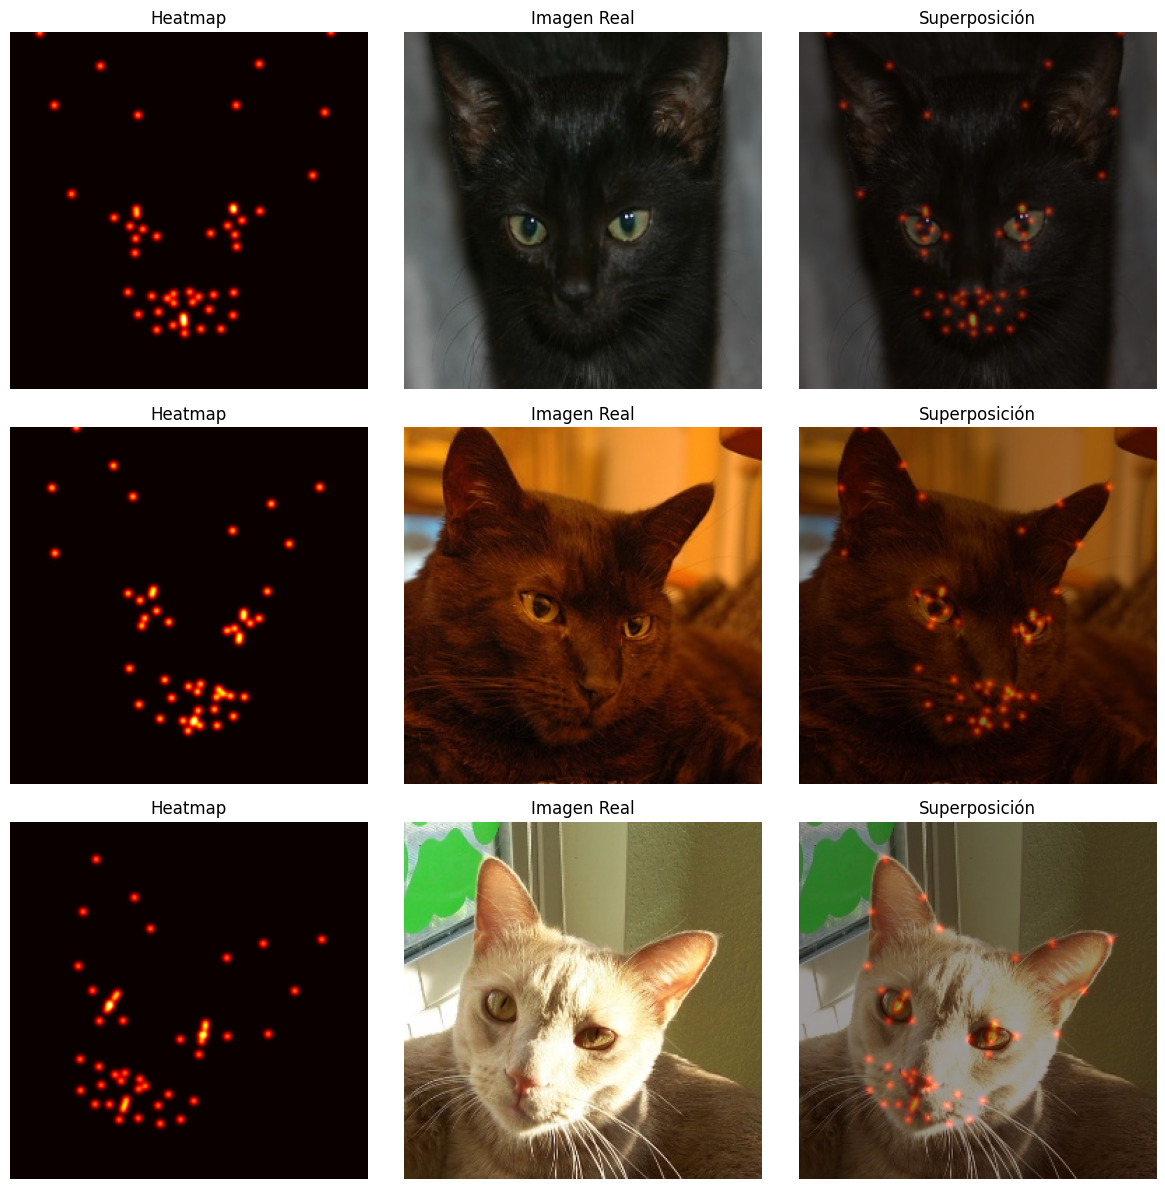

🖼️ Visualización guardada en results/dataset_samples.png

PASO 2: Entrenamiento del Modelo
📊 Dataset: 1663 pares
📊 Dataset: 207 pares


Época 1/100:  11%|█▏        | 8/70 [00:07<00:59,  1.03it/s, D=0.977, G=73.177, L1=71.151]



KeyboardInterrupt: 

In [8]:
if __name__ == "__main__":
    # 1. Visualizar dataset inicial
    print("\n" + "="*60)
    print("PASO 1: Visualización del Dataset")
    print("="*60)
    visualize_dataset("datasets/catflw/train", n=3)
    
    # 2. Entrenar modelo con parámetros mejorados
    print("\n" + "="*60)
    print("PASO 2: Entrenamiento del Modelo")
    print("="*60)
    dataset_root = "datasets/catflw"
    G = train_pix2pix(
        dataset_root, 
        epochs=100,         # Más épocas
        batch_size=24,      # Batch más pequeño
        lambda_L1=150,      # Mayor peso L1
        lambda_perc=2,      # Menor peso perceptual
        lr=0.0002           # Learning rate estándar
    )
    
    # 3. Evaluar en test
    print("\n" + "="*60)
    print("PASO 3: Evaluación en Test Set")
    print("="*60)
    evaluate_on_test(G, os.path.join(dataset_root, "test"))
    
    # 4. Visualizar mejores ejemplos
    print("\n" + "="*60)
    print("PASO 4: Visualización de Mejores Resultados")
    print("="*60)
    test_loader = DataLoader(
        Pix2PixDataset(os.path.join(dataset_root, "test")), 
        batch_size=24,
        shuffle=False
    )
    
    show_samples(
        G, 
        test_loader, 
        device, 
        n=16,
        title="🏆 Mejores 16 Resultados Pix2Pix en Test Set",
        save_path="results/best_samples_test.png"
    )
    
    print("\n✅ Proceso completado exitosamente!")